In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
transform=transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

In [13]:
model = efficientnet_b7(weights = EfficientNet_B7_Weights)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # Two output classes (fake or real)
model = model.to(device)

c:\Users\HUAWEI\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix

model.load_state_dict(torch.load("best_model.pth", map_location=torch.device('cpu')))
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [15]:
image_path = ImageFolder('spectro', transform=transform)
test_images = DataLoader(image_path)

In [68]:
# test loading single image
from torchcam.methods import GradCAMpp
from torchvision.io.image import read_image
from torchvision.transforms.functional import  to_pil_image
img = read_image('spectro/reals/DF_E_2000053.png')

trans_img = transform(to_pil_image((img)).convert('RGB')).to(device)
# label = torch.Tensor([])
cam_extractor =GradCAMpp(model, list(model.children())[-3][-1][0]) 
outputs = model(trans_img.unsqueeze(0))
activation_map = cam_extractor(outputs.squeeze(0).argmax().item(), outputs)
_, predicted = torch.max(outputs.data, 1)
predicted


tensor([1])

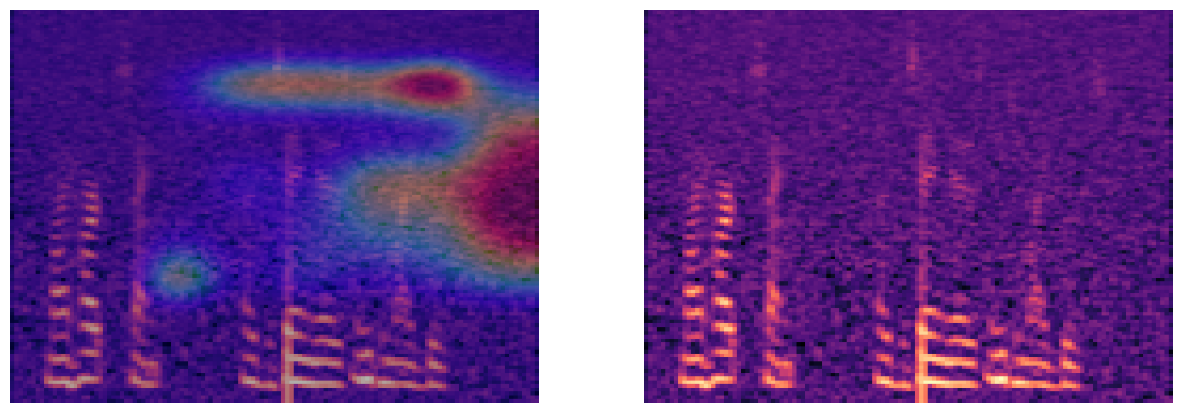

In [65]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask


# plt.imshow(trans_img)
fing, ax = plt.subplots(1,2, figsize=(15,15))
result = overlay_mask(to_pil_image(img).convert('RGB'), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.7)
ax[0].imshow(result)
ax[0].axis('off')
ax[1].imshow(to_pil_image(img).convert('RGB'))
ax[1].axis('off')
plt.show()

In [67]:
modules = list(model.children())
print(type(list(model.children())[-3][-1][0]))

<class 'torch.nn.modules.conv.Conv2d'>
